##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [50]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [51]:
orig_df = pd.read_csv('./data/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [52]:
df = pd.read_csv('./data/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols=['X', 'Y', 'ReportedOn',
                          'Area_Command', 'NIBRSOffenseCode',
                          'VictimCount'])
df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time'] = df['ReportedOn'].dt.hour
df.drop(columns='ReportedOn', inplace=True)

In [53]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [54]:
df = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
         'DayOfWeek', 'Time', 'VictimCount']]

In [55]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [56]:
# Display the first 5 rows of the dataframe df
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


The column X represents the longitude of the location of the incident.  
The column Y represents the latitude of the location of the incident.  
The column Area_Command represents the area-of-command code, which is the police designation of the bureau of the operation.  
The column NIBRSOffenseCode represents the classification code for the crime committed.  
The column DayOfWeek represents the day of the week of the incident.  
The column Time represents the hour of the day of the incident.  
The column VictimCount represents the number of person involved in the accident.

The input variables are X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time.  
The target variable is VictimCount.

In [57]:
# Display the ranges for each column of the dataframe df
column_ranges = df.describe().loc[['min', 'max']]
print(column_ranges)

             X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
min -116.00000  35.068419           0.0               0.0        0.0   0.0   
max -114.62557  37.000000          11.0               2.0        6.0  23.0   

     VictimCount  
min          0.0  
max          6.0  


Ranges for the columns of the dataframe df

| Column | Min | Max |
| --- | ---| --- |
| X | -116 | -114.62557 |
| Y | 35.068419 | 37 |
| Area_Command | 0 | 11 |
| NIBRSOffenseCode | 0 | 2 |
| DayOfWeek | 0 | 6 |
| Time | 0 | 23 |
| VictimCount | 0 | 6 |

We do not have to scale, shift, or normalize the columns Area_Command, NIBRSOffenseCode, DayOfWeek, Time, and VictimCount because we factorized these columns, which encodes categorical data into numerical format. We do not need to scale, shift, or normalize categorical data. However, because columns X and Y represent continuous data, we want to scale the columns to the range [0, 1] since the ranges for columns X and Y can span across infinite values as they are continuous values around the globe.


In [58]:
from sklearn.preprocessing import MinMaxScaler

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
scaler = MinMaxScaler()

# Scale the columns X and Y into the range [0, 1]
df['X'] = scaler.fit_transform(df[['X']])
df['Y'] = scaler.fit_transform(df[['Y']])

In [59]:
# Display the new ranges for each column of the dataframe df
column_ranges = df.describe().loc[['min', 'max']]
print(column_ranges)

       X    Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  VictimCount
min  0.0  0.0           0.0               0.0        0.0   0.0          0.0
max  1.0  1.0          11.0               2.0        6.0  23.0          6.0


New ranges for the columns of the dataframe df

| Column | Min | Max |
| --- | ---| --- |
| X | 0.0 | 1.0 |
| Y | 0.0 | 1.0 |
| Area_Command | 0 | 11 |
| NIBRSOffenseCode | 0 | 2 |
| DayOfWeek | 0 | 6 |
| Time | 0 | 23 |
| VictimCount | 0 | 6 |

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [60]:
# Values of the input variables (inputs)
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values

# Values of the output variable (targets)
Y = df['VictimCount'].values

# Create a Tensor Dataset out of the input and output pytorch tensors
# https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
dataset = TensorDataset(torch.tensor(X), torch.tensor(Y))

# Pick a reasonable batch size
batch_size = 64

# Set the size of the train and test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Randomly split the dataset into train and test set
# https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size])

# Create pytorch dataloader for both train and test set with the batch size
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Iterate over the train loader and display the shape of the batched data
print("\nTraining Data:")
for inputs, targets in train_loader:
    print(f"Inputs Shape: {inputs.shape}, Targets Shape: {targets.shape}")

# Iterate over the test loader and display the shape of the batched data
print("\nTesting Data:")
for inputs, targets in test_loader:
    print(f"Inputs Shape: {inputs.shape}, Targets Shape: {targets.shape}")



Training Data:
Inputs Shape: torch.Size([64, 6]), Targets Shape: torch.Size([64])
Inputs Shape: torch.Size([64, 6]), Targets Shape: torch.Size([64])
Inputs Shape: torch.Size([64, 6]), Targets Shape: torch.Size([64])
Inputs Shape: torch.Size([28, 6]), Targets Shape: torch.Size([28])

Testing Data:
Inputs Shape: torch.Size([55, 6]), Targets Shape: torch.Size([55])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

We will be using Mean Squared Error (MSE) for the loss function because as this is a regression problem, we want to minimize the difference between target and prediction values.    
The size of the predicted output should be 1 since this a regression problem.  
Based on how we tuned the hyperparameters with different values for the learning rate, hidden size of the network, and number of layers, it was shown that we will have a feed-forward neural network with an input layer that takes in input of size 6, 2 hidden layers with the hidden dimensions of size 64, and an output layer that outputs a prediction of size 1 (as it is a regression problem). The hidden layers will use the ReLU activation function.  
We will be using [Adam](https://arxiv.org/abs/1412.6980) for the optimizer as it is straightforward to implement and computationally efficient. The learning rate will be 0.01.  
We trained the model as best as we could with the tested hyperparameter values as the best accuracy of 1.1881. The best accuracy is in MSE because this is a regression problem.    

In [61]:
# Declare input and output sizes for the FFNN
input_size = 6
output_size = 1

# Use Mean Squared Loss (MSE) as the loss function 
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
criterion = nn.MSELoss()

# Declare number of epochs
num_epochs = 100

In [62]:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html
class FFNN(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden_layers, hidden_dim):
        super(FFNN, self).__init__()

        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        # Number of hidden layers of size hidden_dim
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
        x = torch.relu(self.input_layer(x))

        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))

        x = self.output_layer(x)
        
        return x

In [63]:
# Hyperparameters to tune
learning_rates = [0.001, 0.01, 0.1]
hidden_layer_sizes = [32, 64, 128]
num_hidden_layers = [1, 2, 3]

# Store the results here
results = {}

# For each combination of hyperparameters,
for lr, hidden_size, num_layers in product(learning_rates, hidden_layer_sizes, num_hidden_layers):
    # Create a new model with the set of hyperparameters
    model = FFNN(input_size, output_size, num_layers, hidden_size)

    # Utilize the Adam optimizer with the given learning rate
    # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # For each epoch,
    for epoch in range(num_epochs):
        # Set the model in training mode
        model.train()

        # For each batch in train_loader,
        for inputs, targets in train_loader:
            # Convert the inputs to float32
            inputs = inputs.to(torch.float32)

            # Convert the targets to float32 because this is a regression model
            targets = targets.to(torch.float32)

            # Reset gradients of model's parameters to zero
            optimizer.zero_grad()

            # Make predictions
            predictions = model(inputs)

            # Calculate loss between predictions and targets using MSE
            loss = criterion(predictions, targets)

            # Compute gradients using backpropagation
            loss.backward()

            # Update model parameters using the optimizer
            optimizer.step()

        # Set the model in evaluation mode
        model.eval()

        # Turn off gradient tracking for tensors
        with torch.no_grad():
            # Keep track of the cumulative test loss
            test_loss = 0.0

            # For each batch in test_loader,
            for inputs, targets in test_loader:
                # Convert the inputs to float32
                inputs = inputs.to(torch.float32)

                # Convert the targets to float32 because this is a regression model
                targets = targets.to(torch.float32)

                # Make predictions
                predictions = model(inputs)

                # Calculate loss between predictions and targets using MSE
                test_loss += criterion(predictions, targets)

            # Calculate average loss per sample
            test_loss /= len(test_loader)

    # Store the calculated average loss for the set of hyperparameters
    results[(lr, hidden_size, num_layers)] = test_loss.item()

# Find the set of best hyperparameters by finding the key to the minimum test loss value in results
best_lr, best_hidden_size, best_num_layers = min(results, key=results.get)

# Get the value for best test loss using the set of best hyperparameters
best_test_loss = results[(best_lr, best_hidden_size, best_num_layers)]

# Display best hyperparameters and test loss
print(
    f"Learning Rate: {best_lr}\nHidden Layer Size: {best_hidden_size}\nNumber of Layers: {best_num_layers}")
print(f"Test MSE with Best Hyperparameters: {best_test_loss:.4f}")


/Users/danieljo/F23/457/cecs-457/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/danieljo/F23/457/cecs-457/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/danieljo/F23/457/cecs-457/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due t

Learning Rate: 0.01
Hidden Layer Size: 64
Number of Layers: 2
Test MSE with Best Hyperparameters: 1.1881


In [64]:
# Initialize the regression FFNN model using the best hyperparameters
model = FFNN(input_size, output_size, best_num_layers, best_hidden_size)

# Initialize the Adam optimizer using the best learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)


In [65]:
# List of test losses
test_losses = []

# For each epoch,
for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()

    # For each batch in train_loader,
    for inputs, targets in train_loader:
        # Convert the inputs to float32
        inputs = inputs.to(torch.float32)

        # Convert the targets to float32 because this is a regression model
        targets = targets.to(torch.float32)

        # Reset gradients of model's parameters to zero
        optimizer.zero_grad()

        # Make predictions
        predictions = model(inputs)

        # Calculate loss between predictions and targets using MSE
        loss = criterion(predictions, targets)

        # Compute gradients using backpropagation
        loss.backward()

        # Update model parameters using the optimizer
        optimizer.step()

    # Set the model in evaluation mode
    model.eval()
    
    # Turn off gradient tracking for tensors
    with torch.no_grad():
        # Keep track of the cumulative test loss
        test_loss = 0.0

        # For each batch in test_loader,
        for inputs, targets in test_loader:
            # Convert the inputs to float32
            inputs = inputs.to(torch.float32)

            # Convert the targets to float32 because this is a regression model
            targets = targets.to(torch.float32)

            # Make predictions
            predictions = model(inputs)

            # Calculate loss between predictions and targets using MSE
            test_loss += criterion(predictions, targets)

        # Calculate average loss
        test_loss /= len(test_loader)

        # Add test loss to list of test losses
        test_losses.append(test_loss)

    # Display the test loss for the epoch
    print(f"Epoch {epoch+1}, Test MSE: {test_loss.item():.4f}")

# Get the best test loss
best_test_loss = min(test_losses)

# Display best test loss
print(f'\nBest Test Loss: {best_test_loss:.4f}')

Epoch 1, Test MSE: 1.2529
Epoch 2, Test MSE: 1.2370
Epoch 3, Test MSE: 1.2186
Epoch 4, Test MSE: 1.2104
Epoch 5, Test MSE: 1.2128
Epoch 6, Test MSE: 1.1963
Epoch 7, Test MSE: 1.1975
Epoch 8, Test MSE: 1.1919
Epoch 9, Test MSE: 1.1947
Epoch 10, Test MSE: 1.2140
Epoch 11, Test MSE: 1.1926
Epoch 12, Test MSE: 1.2007
Epoch 13, Test MSE: 1.2330
Epoch 14, Test MSE: 1.2172
Epoch 15, Test MSE: 1.1963
Epoch 16, Test MSE: 1.1933
Epoch 17, Test MSE: 1.2006
Epoch 18, Test MSE: 1.1961
Epoch 19, Test MSE: 1.1907
Epoch 20, Test MSE: 1.1906
Epoch 21, Test MSE: 1.1898
Epoch 22, Test MSE: 1.1914
Epoch 23, Test MSE: 1.1902
Epoch 24, Test MSE: 1.1893
Epoch 25, Test MSE: 1.1894
Epoch 26, Test MSE: 1.1890
Epoch 27, Test MSE: 1.2072
Epoch 28, Test MSE: 1.1909
Epoch 29, Test MSE: 1.1941
Epoch 30, Test MSE: 1.1916
Epoch 31, Test MSE: 1.1999
Epoch 32, Test MSE: 1.1959
Epoch 33, Test MSE: 1.1904
Epoch 34, Test MSE: 1.1909
Epoch 35, Test MSE: 1.1902
Epoch 36, Test MSE: 1.1891
Epoch 37, Test MSE: 1.1894
Epoch 38, 

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

The number of classes are the values in the range of the victim count. Because our dataset has victim counts from the range 0 to 6, we set the number of classes to 7 as there can be 7 possible class values. This is equivalent to the output size of the neural network.  
The architecture is different because we tuned the hyperparameters and decided that the feed forward neural network will have an input layer with the same input size, 1 hidden layer with the hidden dimensions of size 128, and an output layer that outputs a prediction of size 7 (probabilities for each class as it is a multi-class classification problem). The hidden layers will also utilize the ReLU activation function.  
We changed the learning rate to 0.1 for the Adam optimizer.  
The loss function is different from the regression model as we utilize Cross Entropy Loss.
The best accuracy that we can get is 52.7273% with the best test loss being 1.0366%.

In [66]:
# Declare input and output sizes for the classification FFNN
input_size = 6
output_size = 7

# Use Cross Entropy Loss as the loss function 
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = nn.CrossEntropyLoss()

# Declare number of epochs
num_epochs = 100

In [67]:
# Hyperparameters to tune
learning_rates = [0.001, 0.01, 0.1]
hidden_layer_sizes = [32, 64, 128]
num_hidden_layers = [1, 2, 3]

# Store the results here
results = {}

# For each combination of hyperparameters,
for lr, hidden_size, num_layers in product(learning_rates, hidden_layer_sizes, num_hidden_layers):
    # Create a new model with the set of hyperparameters
    model = FFNN(input_size, output_size, num_layers, hidden_size)

    # Utilize the Adam optimizer with the given learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # For each epoch,
    for epoch in range(num_epochs):
        # Set the model in training mode
        model.train()

        # For each batch in train_loader,
        for inputs, targets in train_loader:
            # Convert the inputs to float32
            inputs = inputs.to(torch.float32)

            # Convert the targets to long because this is a classifcation model
            targets = targets.to(torch.long)

            # Reset gradients of model's parameters to zero
            optimizer.zero_grad()

            # Make predictions
            predictions = model(inputs)

            # Calculate loss between predictions and targets using MSE
            loss = criterion(predictions, targets)

            # Compute gradients using backpropagation
            loss.backward()

            # Update model parameters using the optimizer
            optimizer.step()

        # Set the model in evaluation mode
        model.eval()

        # Turn off gradient tracking for tensors
        with torch.no_grad():
            # Keep track of the cumulative test loss
            test_loss = 0.0

            # For each batch in test_loader,
            for inputs, targets in test_loader:
                # Convert the inputs to float32
                inputs = inputs.to(torch.float32)

                # Convert the targets to long because this is a classifcation model
                targets = targets.to(torch.long)

                # Make predictions
                predictions = model(inputs)

                # Calculate loss between predictions and targets using Cross Entropy Loss
                test_loss += criterion(predictions, targets)

            # Calculate average loss per sample
            test_loss /= len(test_loader)

    # Store the calculated average loss for the set of hyperparameters
    results[(lr, hidden_size, num_layers)] = test_loss.item()

# Find the set of best hyperparameters by finding the key to the minimum test loss value in results
best_lr, best_hidden_size, best_num_layers = min(results, key=results.get)

# Get the value for best test loss using the set of best hyperparameters
best_test_loss = results[(best_lr, best_hidden_size, best_num_layers)]

# Display best hyperparameters and test loss
print(
    f"Learning Rate: {best_lr}\nHidden Layer Size: {best_hidden_size}\nNumber of Layers: {best_num_layers}")
print(f"Test CrossEntropyLoss with Best Hyperparameters: {best_test_loss:.4f}")


Learning Rate: 0.1
Hidden Layer Size: 128
Number of Layers: 1
Test CrossEntropyLoss with Best Hyperparameters: 1.0731


In [68]:
# Initialize the classification FFNN model using the best hyperparameters
model = FFNN(input_size, output_size, best_num_layers, best_hidden_size)

# Initialize the Adam optimizer using the best learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

In [69]:
# List of test losses
test_losses = []

# List of accuracies
accuracies = []

# For each epoch,
for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()

    # For each batch in train_loader,
    for inputs, targets in train_loader:
        # Convert the inputs to float32
        inputs = inputs.to(torch.float32)

        # Convert the targets to long because this is a classifcation model
        targets = targets.to(torch.long)

        # Reset gradients of model's parameters to zero
        optimizer.zero_grad()

        # Make predictions
        predictions = model(inputs)

        # Calculate loss between predictions and targets using MSE
        loss = criterion(predictions, targets)

        # Compute gradients using backpropagation
        loss.backward()

        # Update model parameters using the optimizer
        optimizer.step()

    # Set the model in evaluation mode
    model.eval()

    # Turn off gradient tracking for tensors
    with torch.no_grad():
        # Keep track of the cumulative test loss
        test_loss = 0.0

        # Keep track of number of correct predictions and number of total samples
        correct_predictions = 0
        total_samples = 0

        # For each batch in test_loader,
        for inputs, targets in test_loader:
            # Convert the inputs to float32
            inputs = inputs.to(torch.float32)

            # Convert the targets to long because this is a classifcation model
            targets = targets.to(torch.long)

            # Make predictions
            predictions = model(inputs)

            # Calculate the test loss using Cross Entropy Loss
            test_loss += criterion(predictions, targets)

            # Get the class with the highest probability
            _, predicted = torch.max(predictions, 1)

            # Get the number of correct predictions by comparing the predicted labels to the true labels
            correct_predictions += (predicted == targets).sum().item()

            # Adds the number of samples in the current batch to total samples
            total_samples += targets.size(0)

        # Calculate accuracy
        accuracy = correct_predictions / total_samples * 100

        # Add to list of accuracies
        accuracies.append(accuracy)

        # Calculate average loss
        test_loss /= len(test_loader)

        # Add to list of test losses
        test_losses.append(test_loss)

    # Display the test loss and accuracy for each epoch
    print(f"Epoch {epoch+1}, Test Loss: {test_loss.item()}, Test Accuracy: {accuracy:.4f}%")

# Get best accuracy and test loss
best_accuracy = max(accuracies)
best_test_loss = min(test_losses)

# Display best accuracy and test loss
print(f'\nBest Accuracy: {best_accuracy:.4f}%\nBest Test Loss: {best_test_loss:.4f}')

Epoch 1, Test Loss: 1.8109663724899292, Test Accuracy: 52.7273%
Epoch 2, Test Loss: 1.173898696899414, Test Accuracy: 47.2727%
Epoch 3, Test Loss: 1.1558406352996826, Test Accuracy: 52.7273%
Epoch 4, Test Loss: 1.1359996795654297, Test Accuracy: 52.7273%
Epoch 5, Test Loss: 1.0569827556610107, Test Accuracy: 52.7273%
Epoch 6, Test Loss: 1.0365769863128662, Test Accuracy: 52.7273%
Epoch 7, Test Loss: 1.0423740148544312, Test Accuracy: 52.7273%
Epoch 8, Test Loss: 1.0540077686309814, Test Accuracy: 52.7273%
Epoch 9, Test Loss: 1.0468319654464722, Test Accuracy: 52.7273%
Epoch 10, Test Loss: 1.0734615325927734, Test Accuracy: 52.7273%
Epoch 11, Test Loss: 1.0677776336669922, Test Accuracy: 52.7273%
Epoch 12, Test Loss: 1.0584160089492798, Test Accuracy: 52.7273%
Epoch 13, Test Loss: 1.0455255508422852, Test Accuracy: 52.7273%
Epoch 14, Test Loss: 1.0950560569763184, Test Accuracy: 40.0000%
Epoch 15, Test Loss: 1.0772546529769897, Test Accuracy: 52.7273%
Epoch 16, Test Loss: 1.075373172760

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

Completing tasks 3 and 4 was interesting as I was able to create a feed forward neural network for the same problem but with a different method (regression and classification). Because the nature of the outputs and evaluation metrics of regression and classification are different, it is difficult to compare the results. However, we find that the best test loss for classification was lower than the best test loss for regression, but this could be biased as we use cross entropy loss for classification and mean squared error for regression. I would say that regression might be a better solution to this problem because if there are crimes of greater victim count, the regression model can predict it. Overall, the accuracy of both the regression and classification models were not as high as desired.

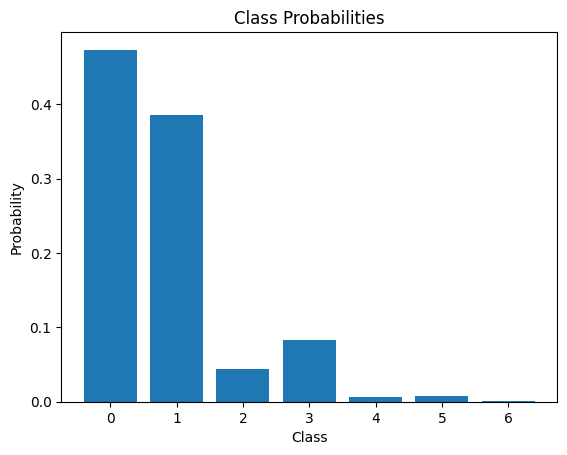

Target Class: 1
Predicted Class: 0


In [70]:
# For every batch in test_loader
for inputs, targets in test_loader:
    # Convert the inputs to float32
    inputs = inputs.to(torch.float32)

    # Convert the targets to long because this is a classification problem
    targets = targets.to(torch.long)

    # Turn off gradient tracking for tensors
    with torch.no_grad():
        # Make predictions
        predictions = model(inputs)

        # Get the probabilities for each class using softmax on the predictions
        # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
        class_probabilities = torch.softmax(predictions, dim=1)

    # Get the most likely predicted class by getting the highest class probability
    _, predictions = torch.max(class_probabilities, 1)

    # Get all the indices where misclassification occurs
    misclassified_indices = (
        predictions != targets).nonzero().squeeze()

    # If there are misclassifications,
    if len(misclassified_indices) > 0:
        # Get the first misclassified index
        i = misclassified_indices[0]

        # Get the target that was misclassified
        target = targets[i].item()

        # Get the prediction that was misclassified
        predictedion = predictions[i].item()

        # Get the class probabilities for that index
        class_probabilities = class_probabilities[i].cpu().numpy()

        break

# Get the number of classes
num_classes = len(class_probabilities)

# Get the class labels into a list
class_labels = [str(i) for i in range(num_classes)]

# Create a bar chart of the class labels and their probabilities
plt.bar(class_labels, class_probabilities)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.title("Class Probabilities")
plt.show()

# Display the target and predicted class
print(f"Target Class: {target}")
print(f"Predicted Class: {predictedion}")

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


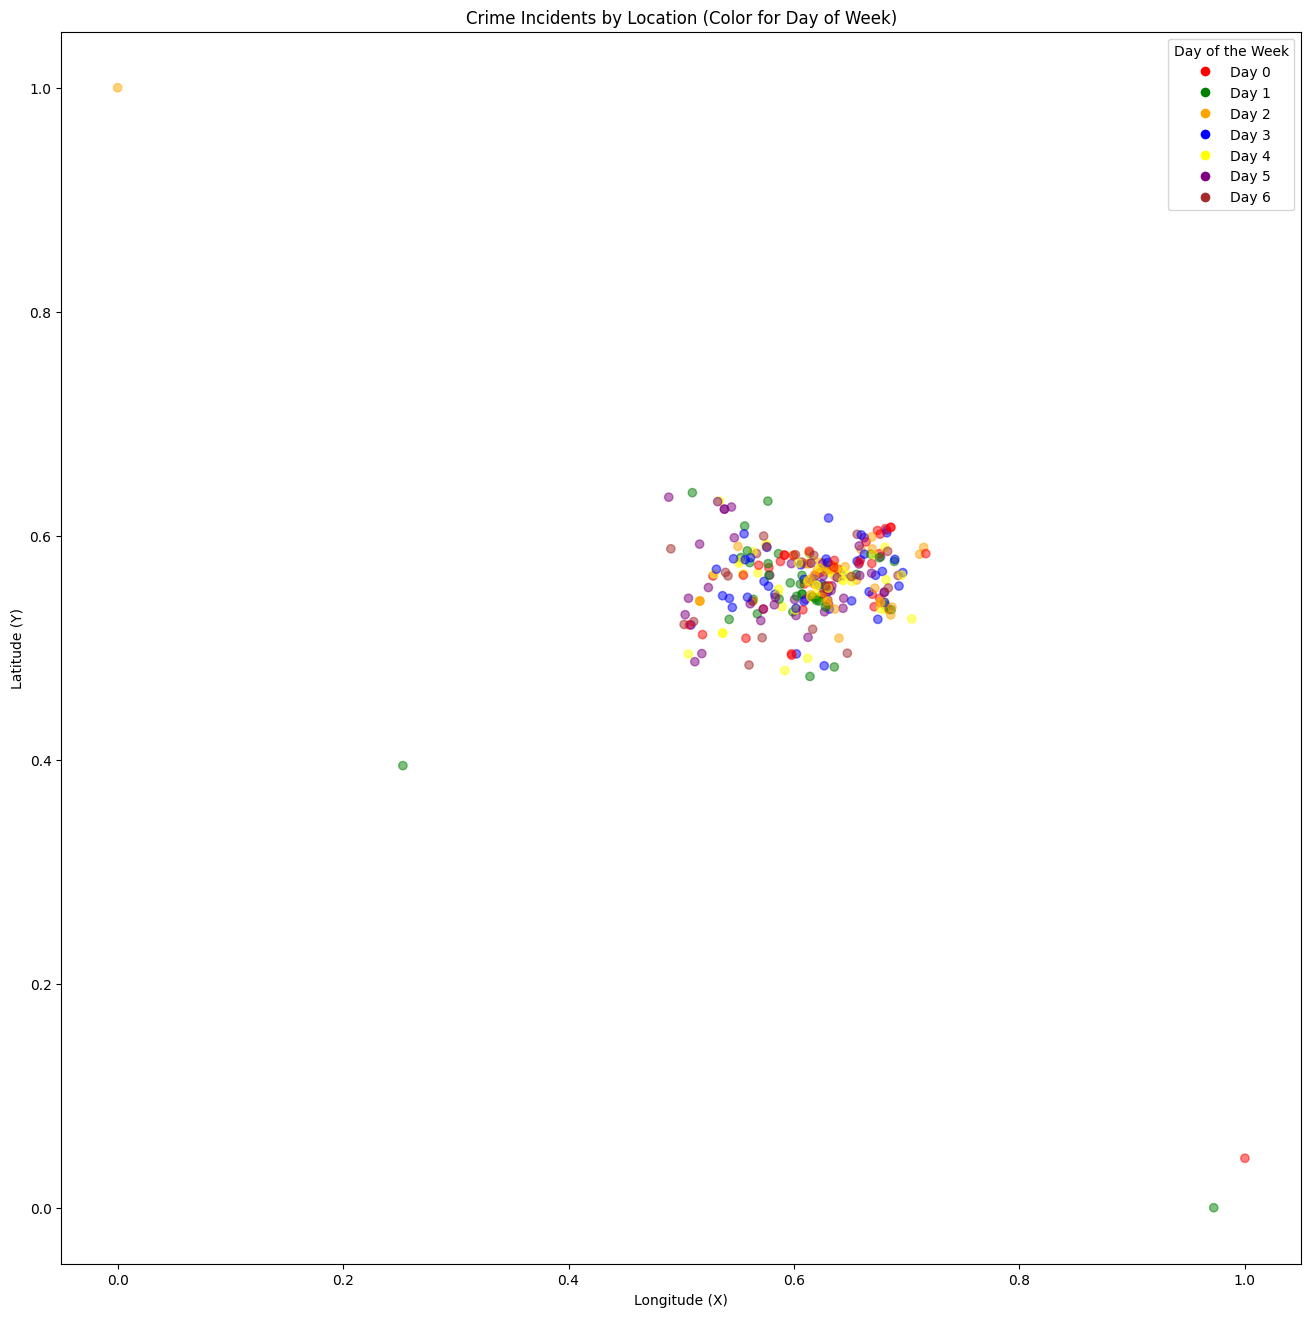

In [71]:
# Corresponding color to day of week
day_of_week_colors = {
    0: 'red',
    1: 'green',
    2: 'orange',
    3: 'blue',
    4: 'yellow',
    5: 'purple',
    6: 'brown'
}

# Create list of colors for each day of the week
colors = [day_of_week_colors[day] for day in df['DayOfWeek']]

# Create a scatter plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
plt.figure(figsize=(16, 16))
plt.scatter(df['X'], df['Y'], c=colors, marker='o', alpha=0.5)
plt.title("Crime Incidents by Location (Color for Day of Week)")
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")

# Create a legend for the scatter plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=day_of_week_colors[i], markersize=8, label=f"Day {i}") for i in range(7)]

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
plt.legend(handles=handles, title='Day of the Week')

# Display scatter plot
plt.show()


Most of the crimes happen in a specific part of Las Vegas where the longitude is in the range [-115.4, -115] and the latitude is in the range [36, 36.3]. The points in that area of Las Vegas have a variety of colors, so it is difficult to determine if there is a correlation between location and the days of the week.

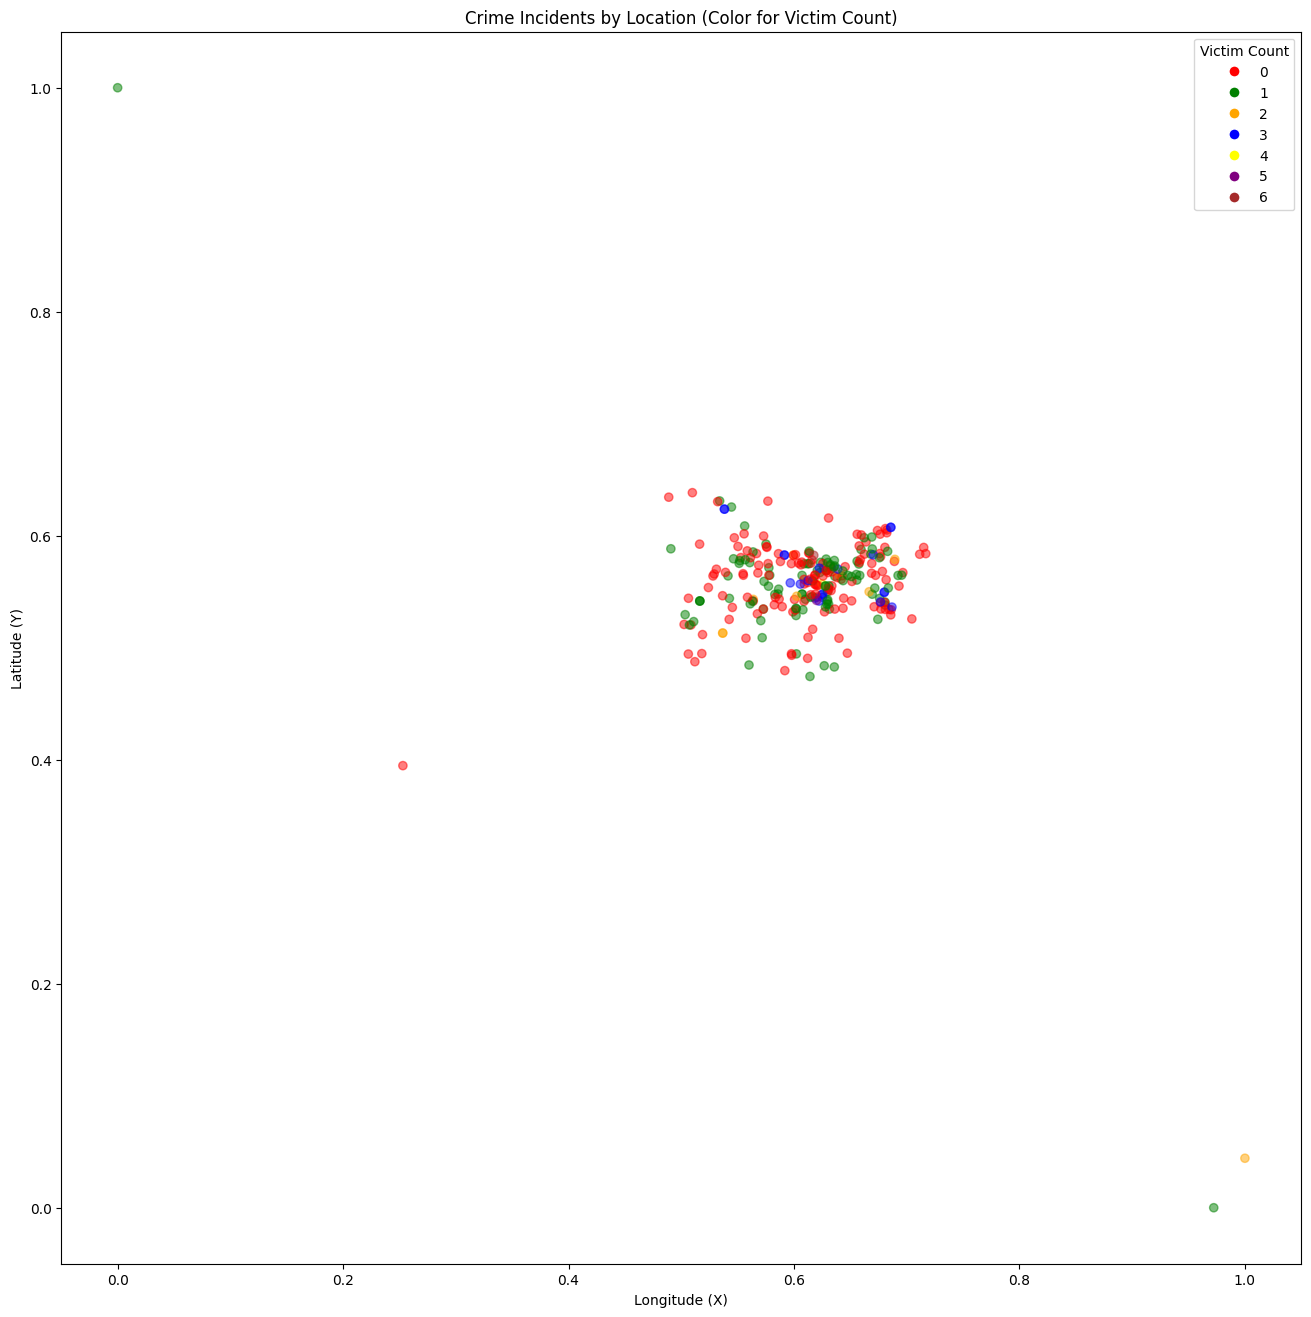

In [72]:
# Corresponding color to victim count
victim_count_colors = {
    0: 'red',
    1: 'green',
    2: 'orange',
    3: 'blue',
    4: 'yellow',
    5: 'purple',
    6: 'brown'
}

# Create list of colors for each victim count
victim_counts = [victim_count_colors[vc] for vc in df['VictimCount']]

# Create scatter plot
plt.figure(figsize=(16, 16))
plt.scatter(df['X'], df['Y'], c=victim_counts, marker='o', alpha=0.5)
plt.title("Crime Incidents by Location (Color for Victim Count)")
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")

# Create legend for scatter plot
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      markerfacecolor=victim_count_colors[count], markersize=8, label=count) for count in range(7)]

plt.legend(handles=handles, title='Victim Count')

# Display scatter plot
plt.show()

Like the previous scatter plot, we notice that most of the crimes happen in a specific part of Las Vegas where the longitude is in the range [-115.4, -115] and the latitude is in the range [36, 36.3]. There are also a lot of crimes that have 0 or 1 victims as the red and green are more common than other colors. The next victim count that is common is 3.

In [73]:
# Sort the days of the week by the number of occurrences (crime count)
sorted_day_counts_df = df['DayOfWeek'].value_counts().sort_values(ascending=False)
sorted_day_counts_df.name = 'CrimeCount'

# Display the days of the week sorted by crime count
print(sorted_day_counts_df)

DayOfWeek
4    51
3    44
5    43
0    40
1    37
2    32
6    28
Name: CrimeCount, dtype: int64


The most frequent days are closer to the weekend (Friday, Thursday, and Saturday)